In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from collections import defaultdict

---

In [2]:
subset_csv_path = 'nuscenes_objects_features_classification_subset.csv'
subset_df = pd.read_csv(subset_csv_path)

---

Grouped class distribution for classification:
annotation
Car               239069
Large Vehicles     96911
Other              35318
Pedestrian         17966
Twowheels           6077
Name: count, dtype: int64

Using 5 classes with at least 5 samples each
Filtered dataset shape: (395341, 30)

Encoded class labels: [('Car', 0), ('Large Vehicles', 1), ('Other', 2), ('Pedestrian', 3), ('Twowheels', 4)]
Training set size: 276738
Test set size: 118603

Classification Report:
                precision    recall  f1-score   support

           Car       0.71      0.92      0.80     71721
Large Vehicles       0.78      0.49      0.60     29074
         Other       0.50      0.18      0.27     10595
    Pedestrian       0.70      0.46      0.55      5390
     Twowheels       0.65      0.05      0.09      1823

      accuracy                           0.72    118603
     macro avg       0.67      0.42      0.46    118603
  weighted avg       0.71      0.72      0.69    118603


Top 10 Most Import

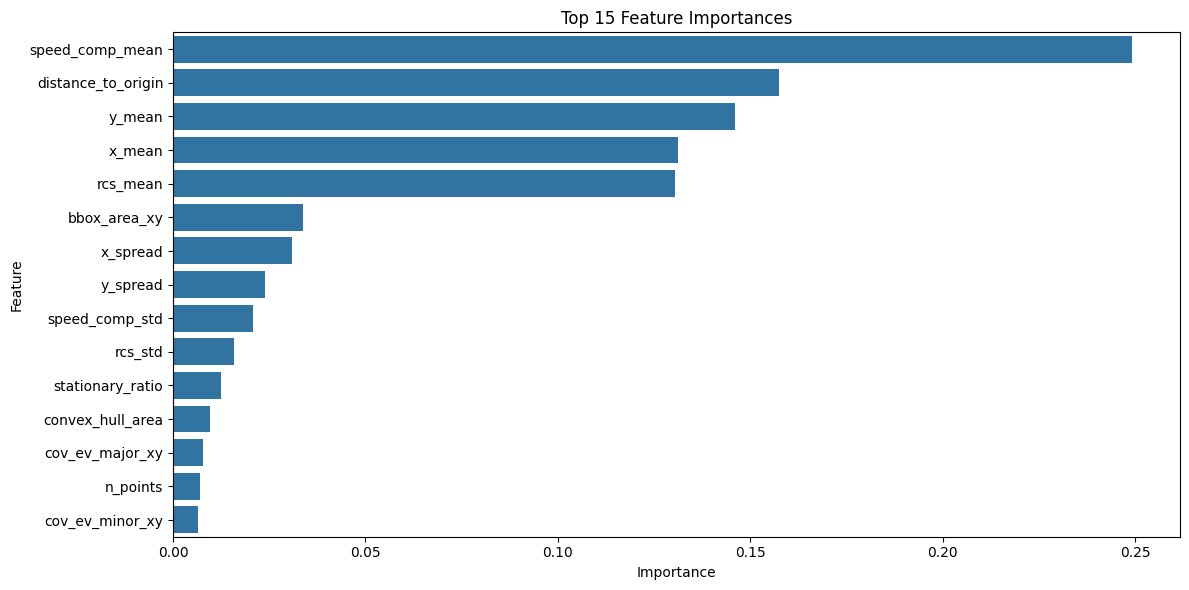

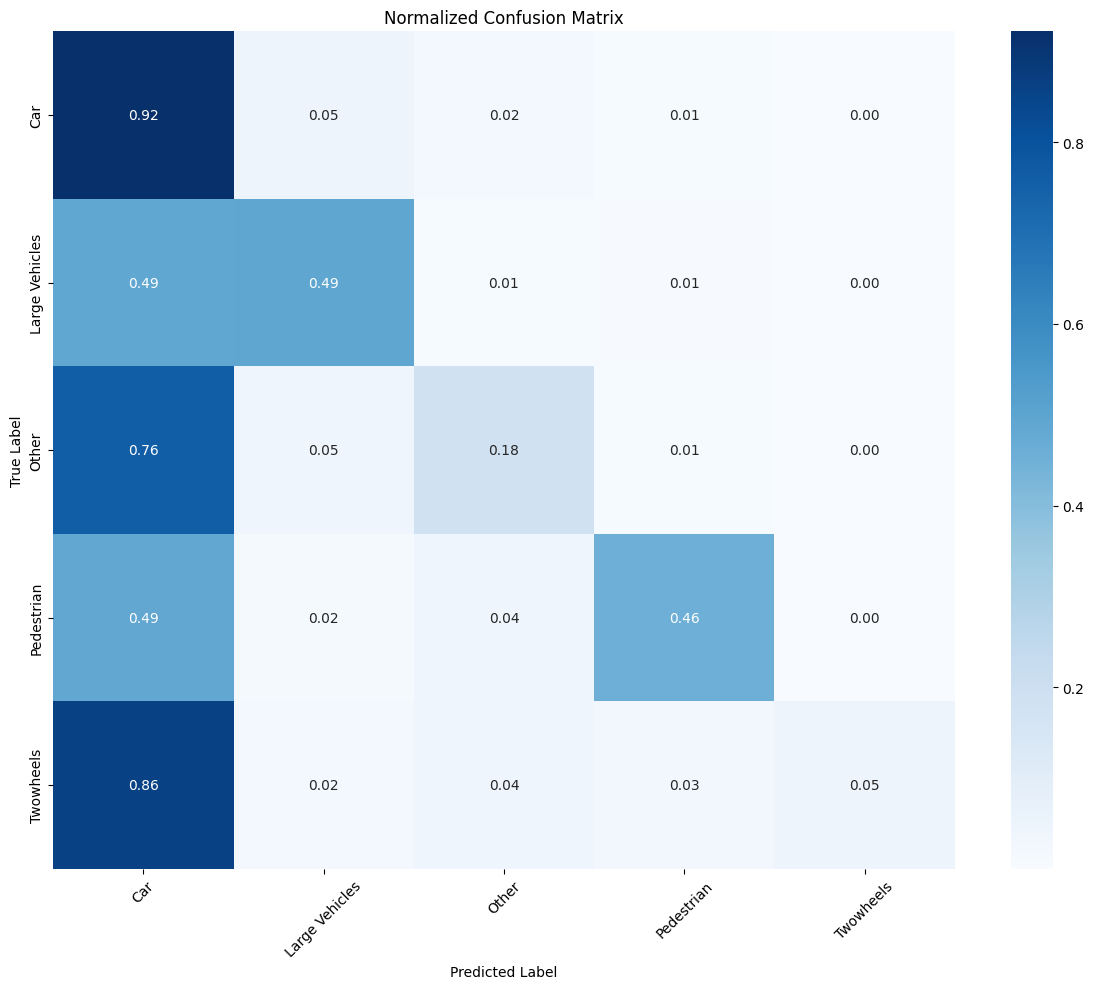

Classification example completed!


In [3]:
print("Grouped class distribution for classification:")
class_counts = subset_df['annotation'].value_counts()
print(class_counts)

# Keep only classes with at least 5 samples
min_samples_per_class = 5
valid_classes = class_counts[class_counts >= min_samples_per_class].index
print(f"\nUsing {len(valid_classes)} classes with at least {min_samples_per_class} samples each")

# Filter dataset to only include these classes
filtered_df = subset_df[subset_df['annotation'].isin(valid_classes)]
print(f"Filtered dataset shape: {filtered_df.shape}")

# Extract features and labels
id_columns = [col for col in filtered_df.columns if col in ['instance_token', 'timestamp', 'scene_name', 'annotation', 'original_annotation', 'sensor', 'radar_channel']]
X = filtered_df.drop(id_columns, axis=1)

# Convert string labels to integers using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(filtered_df['annotation'])
print(f"\nEncoded class labels: {list(zip(le.classes_, range(len(le.classes_))))}")
y = y_encoded

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None, 
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get the original class names from the label encoder
class_names = le.classes_

# Display the confusion matrix with class names
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification example completed!")

In [4]:
clf.estimators_[0].get_depth()

51

In [5]:
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, len(X_train[:1])]))]
# Convert the model to ONNX format
onx_model = to_onnx(clf, initial_type) # X_train[:1] provides a sample input

with open("random_forest_v1_32.onnx", "wb") as f:
    f.write(onx_model.SerializeToString())

---


Classification Report:
                precision    recall  f1-score   support

           Car       0.80      0.34      0.47     71721
Large Vehicles       0.54      0.57      0.55     29074
         Other       0.19      0.81      0.31     10595
    Pedestrian       0.27      0.55      0.37      5390
     Twowheels       0.06      0.05      0.06      1823

      accuracy                           0.44    118603
     macro avg       0.37      0.46      0.35    118603
  weighted avg       0.64      0.44      0.47    118603


Top 10 Most Important Features:
               Feature  Importance
10     speed_comp_mean    0.237640
8         bbox_area_xy    0.134118
12            rcs_mean    0.099399
17    convex_hull_area    0.085270
6             y_spread    0.082076
5             x_spread    0.080552
0             n_points    0.059058
19         circularity    0.042019
1   distance_to_origin    0.041996
23    stationary_ratio    0.031792


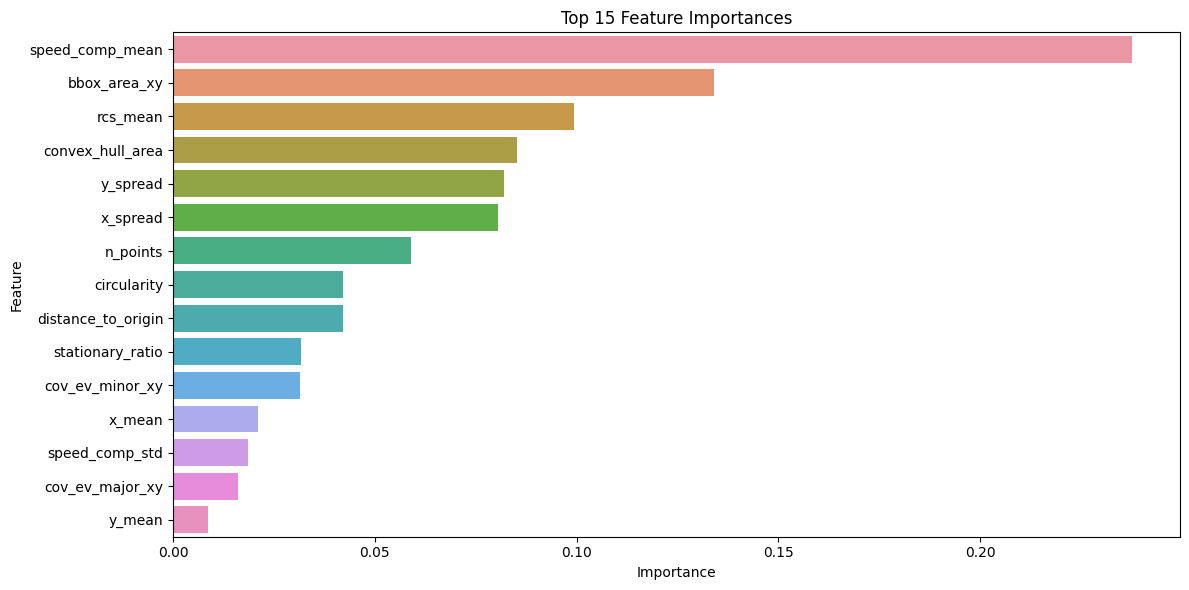

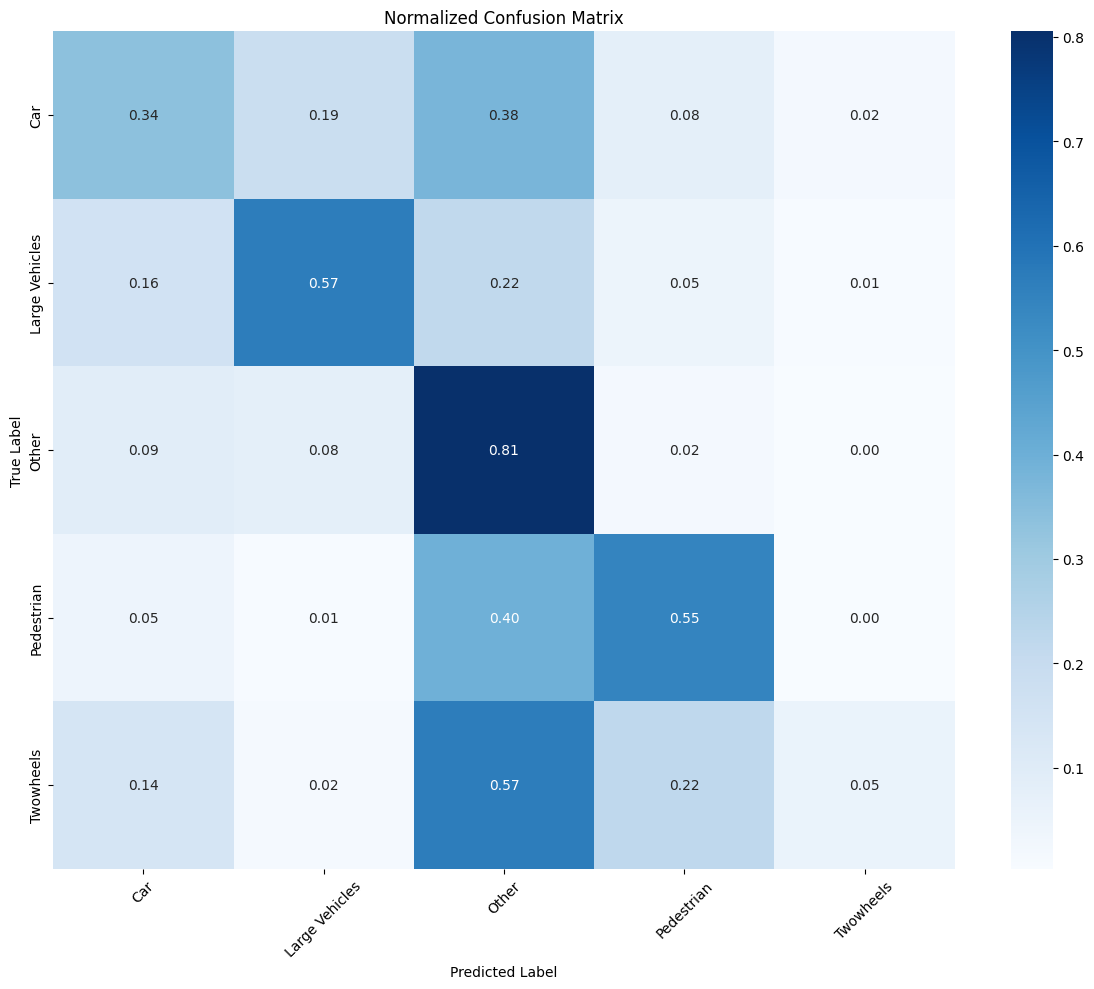

In [6]:
clf_reduced = RandomForestClassifier(
    n_estimators=20, 
    max_depth=5, 
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

clf_reduced.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_reduced.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf_reduced.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get the original class names from the label encoder
class_names = le.classes_

# Display the confusion matrix with class names
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, len(X_train[:1])]))]
# Convert the model to ONNX format
onx_model = to_onnx(clf_reduced, initial_type) # X_train[:1] provides a sample input

with open("random_forest_v1_reduced_32.onnx", "wb") as f:
    f.write(onx_model.SerializeToString())

---


Classification Report:
                precision    recall  f1-score   support

           Car       0.77      0.67      0.72     71721
Large Vehicles       0.70      0.54      0.61     29074
         Other       0.27      0.65      0.38     10595
    Pedestrian       0.52      0.56      0.54      5390
     Twowheels       0.12      0.18      0.15      1823

      accuracy                           0.62    118603
     macro avg       0.48      0.52      0.48    118603
  weighted avg       0.69      0.62      0.64    118603


Top 10 Most Important Features:
               Feature  Importance
10     speed_comp_mean    0.266768
12            rcs_mean    0.123746
1   distance_to_origin    0.122539
3               y_mean    0.112161
2               x_mean    0.101072
8         bbox_area_xy    0.049787
5             x_spread    0.039117
6             y_spread    0.038172
11      speed_comp_std    0.029786
17    convex_hull_area    0.026230


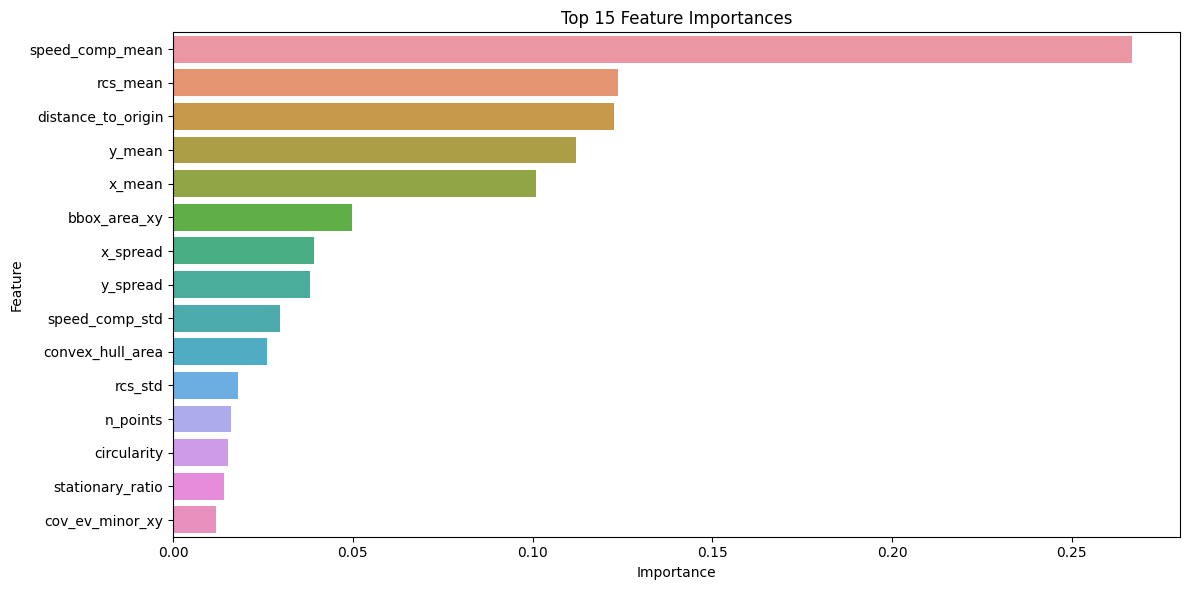

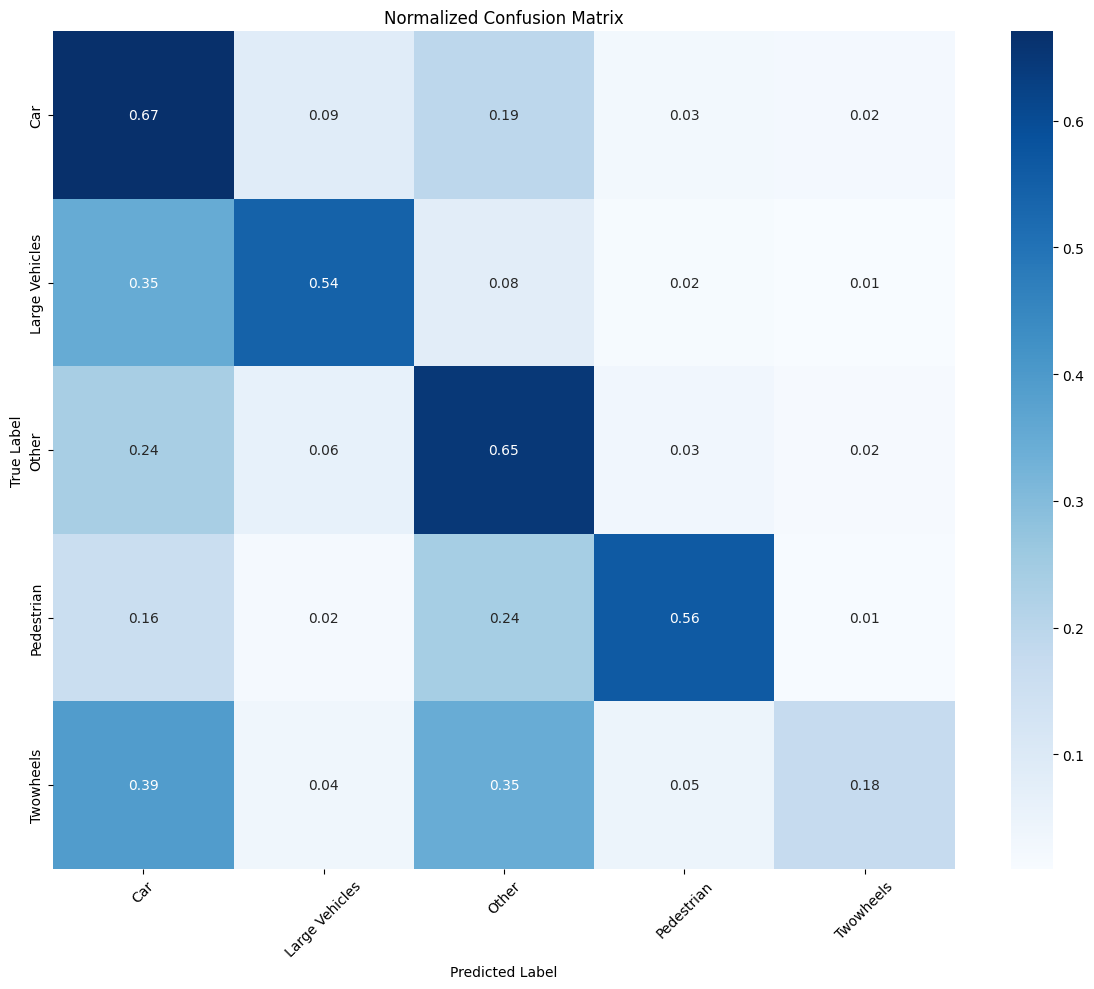

In [7]:
clf_reduced_2 = RandomForestClassifier(
    n_estimators=20, 
    max_depth=20, 
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

clf_reduced_2.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_reduced_2.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf_reduced_2.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get the original class names from the label encoder
class_names = le.classes_

# Display the confusion matrix with class names
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
initial_type = [('float_input', FloatTensorType([None, len(X_train[:1])]))]
# Convert the model to ONNX format
onx_model = to_onnx(clf_reduced_2, initial_type) # X_train[:1] provides a sample input

with open("random_forest_v1_reduced_2_32.onnx", "wb") as f:
    f.write(onx_model.SerializeToString())

---

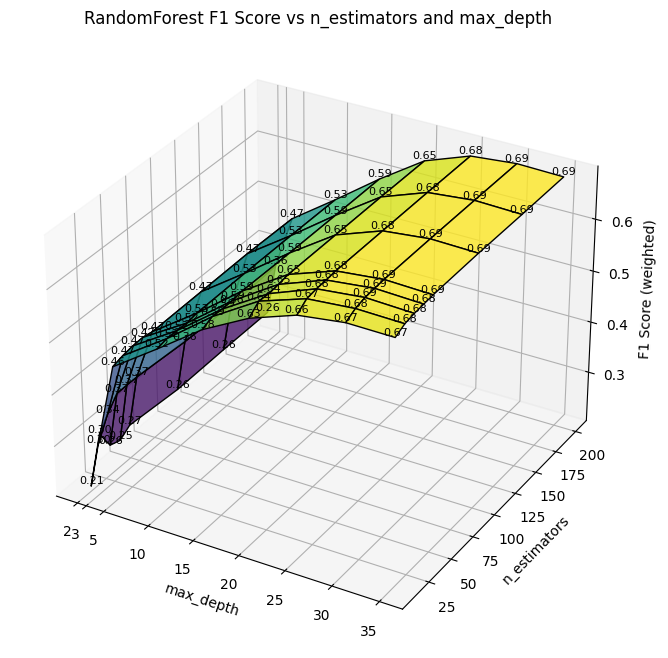

In [ ]:
from sklearn.metrics import f1_score
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

# Define parameter ranges
n_estimators_range = [10, 20, 30, 40, 50, 100, 150, 200]
max_depth_range = [2, 3, 5, 10, 15, 20, 25, 30, 35]

# Prepare grid for results
f1_scores = np.zeros((len(n_estimators_range), len(max_depth_range)))

for i, n_estimators in enumerate(n_estimators_range):
    for j, max_depth in enumerate(max_depth_range):
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth if max_depth is not None else None,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores[i, j] = f1


max_depth_numeric = [md if md is not None else 40 for md in max_depth_range]
max_depth_labels = [str(md) if md is not None else "None" for md in max_depth_range]
X, Y = np.meshgrid(max_depth_numeric, n_estimators_range)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, f1_scores, cmap='viridis', edgecolor='k', alpha=0.8)

# Annotate F1 scores on the surface
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        ax.text(
            X[i, j], Y[i, j], f1_scores[i, j],
            f"{f1_scores[i, j]:.2f}",
            color='black', fontsize=8, ha='center', va='bottom'
        )

ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('F1 Score (weighted)')
ax.set_title('RandomForest F1 Score vs n_estimators and max_depth')

# Set custom ticks for max_depth axis
ax.set_xticks(max_depth_numeric)
ax.set_xticklabels(max_depth_labels)

plt.show()


Classification Report:
                precision    recall  f1-score   support

           Car       0.75      0.80      0.77     71721
Large Vehicles       0.76      0.51      0.61     29074
         Other       0.33      0.52      0.40     10595
    Pedestrian       0.62      0.52      0.57      5390
     Twowheels       0.27      0.10      0.15      1823

      accuracy                           0.68    118603
     macro avg       0.54      0.49      0.50    118603
  weighted avg       0.70      0.68      0.68    118603


Top 10 Most Important Features:
               Feature  Importance
10     speed_comp_mean    0.249409
1   distance_to_origin    0.141890
3               y_mean    0.132286
12            rcs_mean    0.129730
2               x_mean    0.118172
8         bbox_area_xy    0.039003
5             x_spread    0.037730
6             y_spread    0.030772
11      speed_comp_std    0.024776
13             rcs_std    0.020408


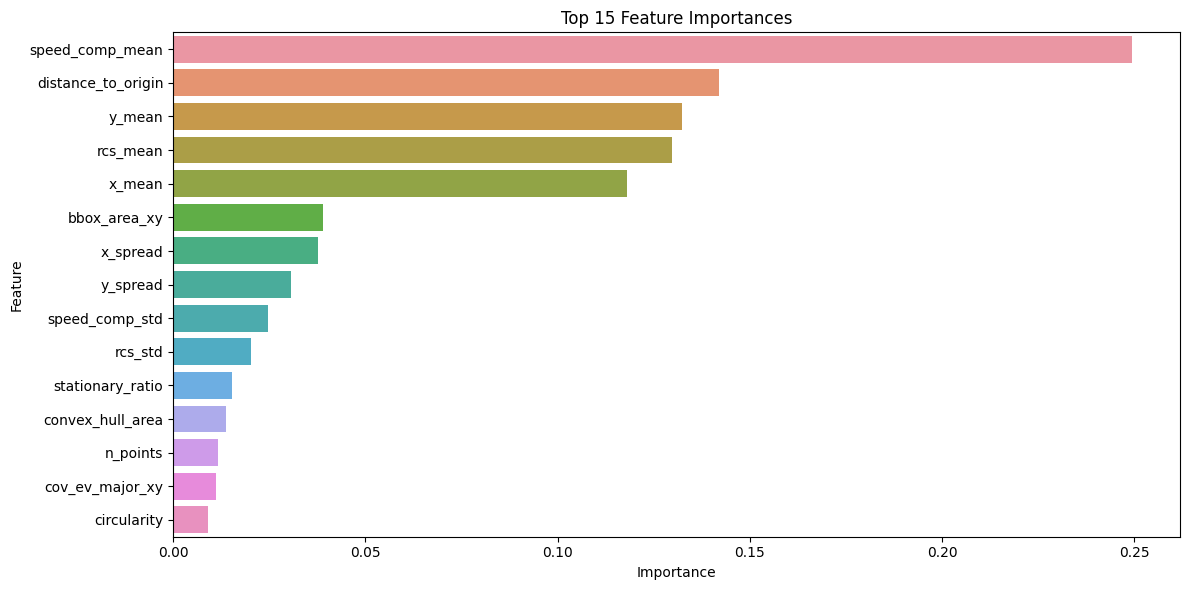

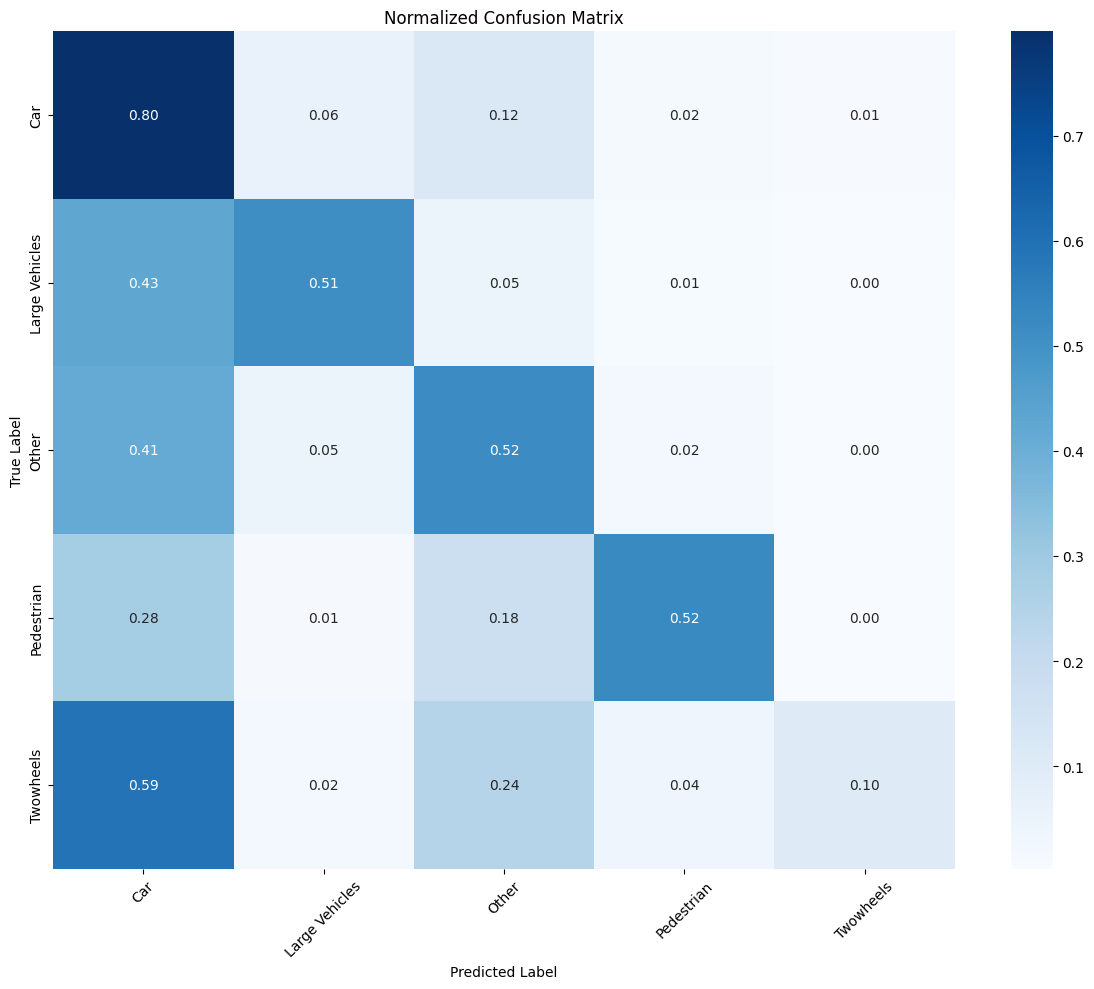

In [8]:
clf_reduced_3 = RandomForestClassifier(
    n_estimators=50, 
    max_depth=25, 
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

clf_reduced_3.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_reduced_3.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf_reduced_3.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get the original class names from the label encoder
class_names = le.classes_

# Display the confusion matrix with class names
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, len(X_train[:1])]))]
# Convert the model to ONNX format
onx_model = to_onnx(clf_reduced_3, initial_type) # X_train[:1] provides a sample input

with open("random_forest_v1_reduced_50_25_32.onnx", "wb") as f:
    f.write(onx_model.SerializeToString())

---

In [28]:
import os

from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType

n_estimators_range = [10, 20, 30, 40, 50, 100, 150]
max_depth_values = [15, 20, 25]
onnx_sizes = {md: [] for md in max_depth_values}

for max_depth in max_depth_values:
    for n_estimators in n_estimators_range:
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        clf.fit(X_train, y_train)
        initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
        onx_model = to_onnx(clf, initial_type)
        filename = f"rf_n{n_estimators}_d{max_depth}.onnx"
        with open(filename, "wb") as f:
            f.write(onx_model.SerializeToString())
        size_mb = os.path.getsize(filename) / (1024 * 1024)
        onnx_sizes[max_depth].append(size_mb)
        os.remove(filename)

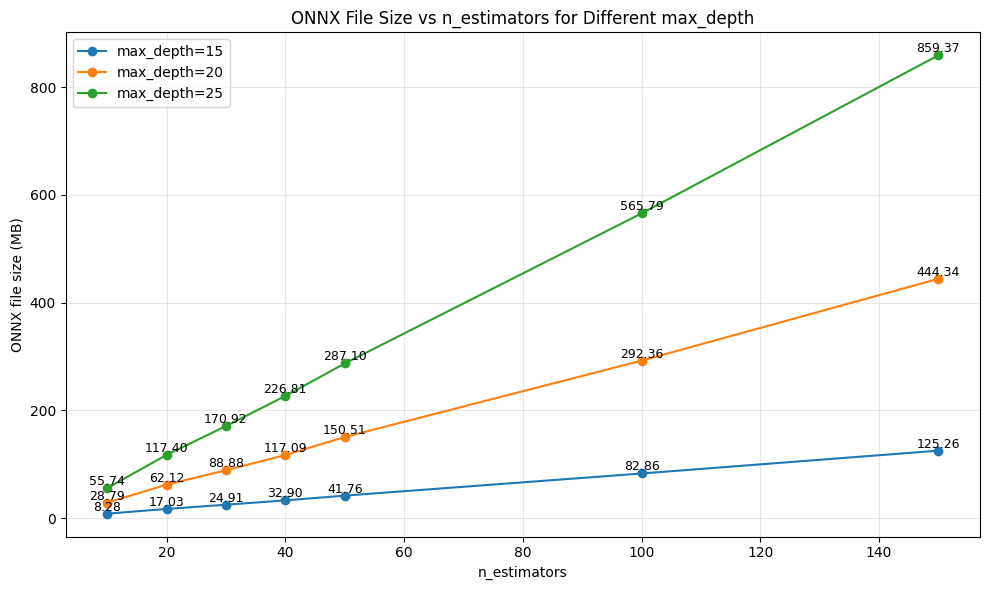

In [30]:
plt.figure(figsize=(10, 6))

for max_depth in max_depth_values:
    yvals = onnx_sizes[max_depth]
    plt.plot(n_estimators_range, yvals, marker='o', label=f"max_depth={max_depth}")
    for x, y in zip(n_estimators_range, yvals):
        plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.xlabel("n_estimators")
plt.ylabel("ONNX file size (MB)")
plt.title("ONNX File Size vs n_estimators for Different max_depth")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

Training specialized models (one per class)...
Training classifier for class: Car
Training F1 for Car: 0.8500
Test F1 for Car: 0.7733
----------------------------------------------------------------------------------------------------
Training classifier for class: Large Vehicles
Training F1 for Large Vehicles: 0.8276
Test F1 for Large Vehicles: 0.6256
----------------------------------------------------------------------------------------------------
Training classifier for class: Other
Training F1 for Other: 0.5310
Test F1 for Other: 0.3920
----------------------------------------------------------------------------------------------------
Training classifier for class: Pedestrian
Training F1 for Pedestrian: 0.4664
Test F1 for Pedestrian: 0.3660
----------------------------------------------------------------------------------------------------
Training classifier for class: Twowheels
Training F1 for Twowheels: 0.1647
Test F1 for Twowheels: 0.0829
------------------------------------

Text(120.72222222222221, 0.5, 'True Label')

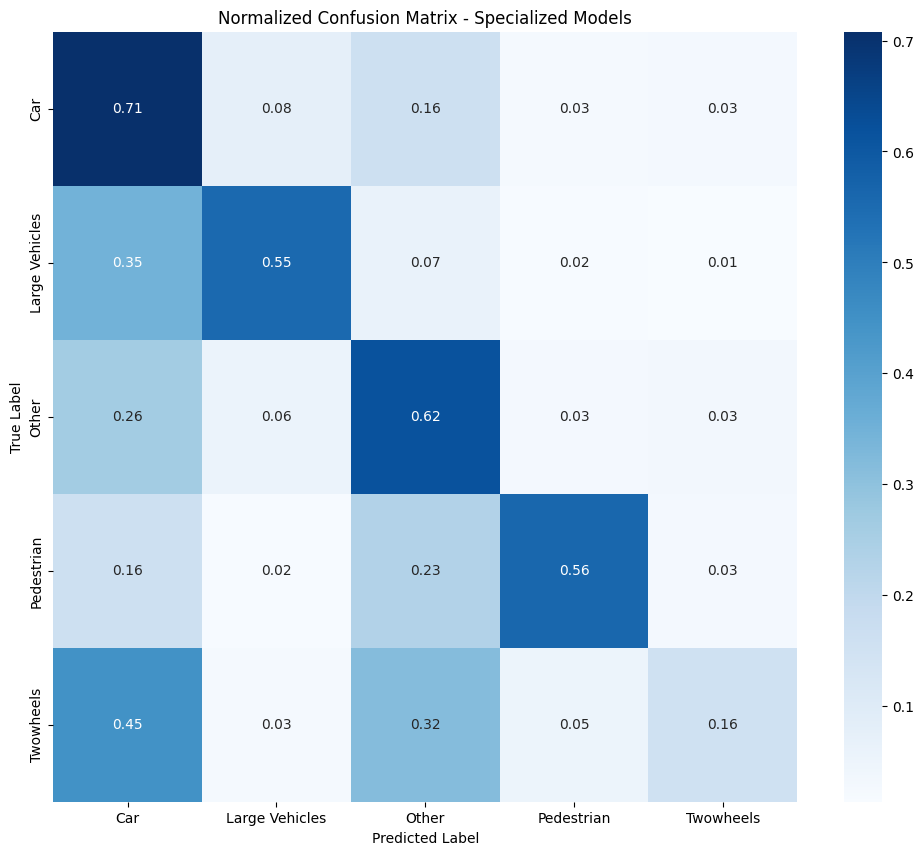

In [ ]:
# Dictionary to store models specialized for each class
specialized_models = {}
class_indices = {}

# Train one model per class
for idx, class_name in enumerate(le.classes_):
    print(f"Training classifier for class: {class_name}")
    
    y_binary = (y_train == idx).astype(int)
    class_indices[idx] = class_name
    
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=20,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_binary)
    specialized_models[idx] = model
    
    train_pred = model.predict(X_train)
    train_acc = f1_score(y_binary, train_pred)
    print(f"Training F1 for {class_name}: {train_acc:.4f}")

    y_test_binary = (y_test == idx).astype(int)
    test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test_binary, test_pred)
    print(f"Test F1 for {class_name}: {test_f1:.4f}")
    print("-"*100)


def predict_with_specialized_models(X):
    class_scores = defaultdict(list)
    
    for class_idx, model in specialized_models.items():
        # Get probability of positive class (class 1)
        probas = model.predict_proba(X)[:, 1]
        class_scores[class_idx] = probas
    
    # Convert to numpy arrays for easy manipulation
    scores_array = np.zeros((X.shape[0], len(specialized_models)))
    for class_idx, scores in class_scores.items():
        scores_array[:, class_idx] = scores
    
    # Return the class with highest probability for each sample
    return np.argmax(scores_array, axis=1)

# Evaluate on test set
print("\nEvaluating ensemble of specialized models...")
y_pred_specialized = predict_with_specialized_models(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_specialized)
f1 = f1_score(y_test, y_pred_specialized, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_specialized, target_names=le.classes_))

# Compare with standard multi-class classifier
print("\nComparison with standard multi-class classifier:")
standard_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
standard_clf.fit(X_train, y_train)
y_pred_standard = standard_clf.predict(X_test)

standard_accuracy = accuracy_score(y_test, y_pred_standard)
standard_f1 = f1_score(y_test, y_pred_standard, average='weighted')

print(f"Standard Model Accuracy: {standard_accuracy:.4f}")
print(f"Standard Model F1 Score: {standard_f1:.4f}")
print(f"Specialized Models Accuracy: {accuracy:.4f}")
print(f"Specialized Models F1 Score: {f1:.4f}")

# Confusion matrix for specialized models
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_specialized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix - Specialized Models')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')